In [1]:
from pathlib import Path; import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent); os.chdir(set_path)

In [2]:
import tensorflow as tf
#tf.config.run_functions_eagerly(True)
from Utils.load_plain_mnist import x_train, x_test, train_ds, test_ds, image_dim, y_train
from Inverse_Autoregressive_Flow.IAF_VAE import IAF_VAE
import matplotlib.pyplot as plt
import datetime

import numpy as np
import matplotlib as mpl

In [3]:
x_train = x_train[0:4, :, :, :]
y_train = y_train[0:4]

In [4]:
x_train_4_points= np.repeat(x_train, 5000, axis=0)

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices(x_train_4_points).shuffle(10000).batch(256)

In [6]:
latent_representation_dim = 2
EPOCHS = 10
name = ""
# Define vae
IAF_vae = IAF_VAE(latent_representation_dim, x_dim=image_dim,
                 n_autoregressive_units=4, autoregressive_unit_layer_width=120,
                 First_Encoder_to_IAF_step_dim=1,
                 encoder_FC_layer_nodes=120)

In [7]:
train_history = []
test_history = []
step_counter = 0
for epoch in range(EPOCHS):
    total_train_loss = 0
    for images in train_ds:
        ELBO, log_prob_x_given_z_decode_batch, log_probs_z_given_x_batch, log_prob_z_prior_batch = IAF_vae.train_step(images)
        total_train_loss -= ELBO

    train_history.append(total_train_loss / len(train_ds))

    print(
        f'Epoch {epoch + 1}, '
        f'\n Loss: {total_train_loss.numpy() / len(train_ds)}')

Epoch 1, 
 Loss: 292.39833860759495
Epoch 2, 
 Loss: 87.07258084454114
Epoch 3, 
 Loss: 71.33279766613924
Epoch 4, 
 Loss: 65.3605802511867
Epoch 5, 
 Loss: 62.30155384691456
Epoch 6, 
 Loss: 60.52021113528481
Epoch 7, 
 Loss: 59.38136619857595
Epoch 8, 
 Loss: 58.24011694026899
Epoch 9, 
 Loss: 57.614121835443036
Epoch 10, 
 Loss: 56.721636422072784


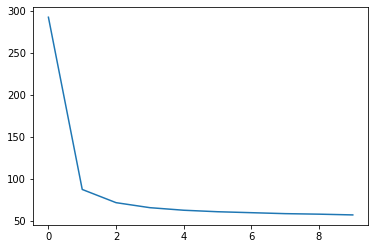

In [8]:
plt.plot(train_history)
plt.plot(test_history)
plt.show()

# Visualise Predictions

### original

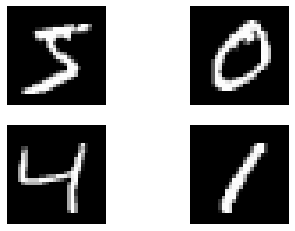

In [9]:
n = 2
fig, axs = plt.subplots(n,n)
for i in range(n*n):
    row = int(i/n)
    col = i % n
    axs[row, col].imshow(x_train[i, :, :], cmap="gray")
    axs[row, col].axis('off')

### Predicted

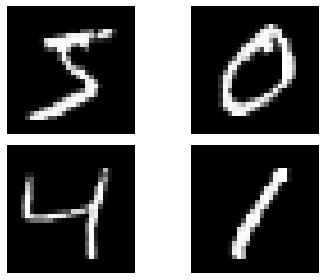

In [10]:
n = 2
reconstruction= IAF_vae(x_train[0:n*n, :, :])[0]
reconstruction = tf.nn.sigmoid(reconstruction)
fig, axs = plt.subplots(n,n)
for i in range(n*n):
    row = int(i/n)
    col = i % n
    axs[row, col].imshow(reconstruction[i, :, :], cmap="gray")
    axs[row, col].axis('off')
fig.tight_layout()

# Make GIF

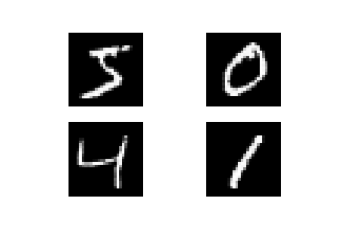

In [11]:
images = []
n = 2
n_images = 40
for gif_n in range(n_images):
    reconstruction= IAF_vae(x_train[0:n*n, :, :])[0]
    reconstruction = tf.nn.sigmoid(reconstruction)
    fig, axs = plt.subplots(n,n)
    for i in range(n*n):
        row = int(i/n)
        col = i % n
        axs[row, col].imshow(reconstruction[i, :, :], cmap="gray")
        axs[row, col].axis('off')
    fig.savefig("Inverse_Autoregressive_Flow/GIF/" + str(gif_n) + ".png")
    plt.close()

import matplotlib.animation as animation
fig, ax = plt.subplots()
ax.axis('off')
#plt.close()
images = []
files = ["Inverse_Autoregressive_Flow/GIF/" + str(i) + ".png" for i in range(n_images)]
for f in files:
    im=plt.imread(f)
    img = plt.imshow(im, animated=True)
    images.append([img])

animation_result = animation.ArtistAnimation(fig, images, interval=1000, blit=True,
                                repeat_delay=1000)
animation_result

Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
animation_result.save("Inverse_Autoregressive_Flow/GIF/im.mp4", writer=writer)

# Visualise encoding in 2D

# Here we want to see weird shapes!

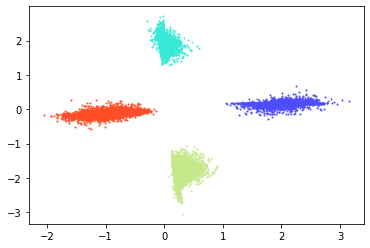

In [14]:
n_points = 4
cols = cmap=mpl.cm.rainbow(np.linspace(0.1, 0.9, n_points))
points = []
for point_n in range(0, n_points):
    point_repeat = np.zeros((5000, 28, 28, 1))
    point_repeat[: :, :, :] = x_train[point_n, :, :]
    encoding_2D = IAF_vae.get_encoding(point_repeat)
    plt.scatter(encoding_2D[:, 0], encoding_2D[:, 1], color=cols[point_n], s=1, )

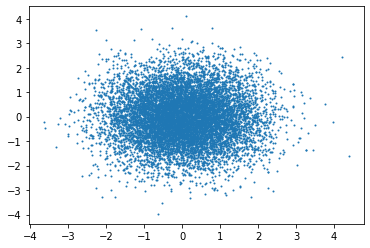

In [15]:
prior = np.random.standard_normal((10000, 2))
plt.scatter(prior[:, 0], prior[:, 1], s=1)